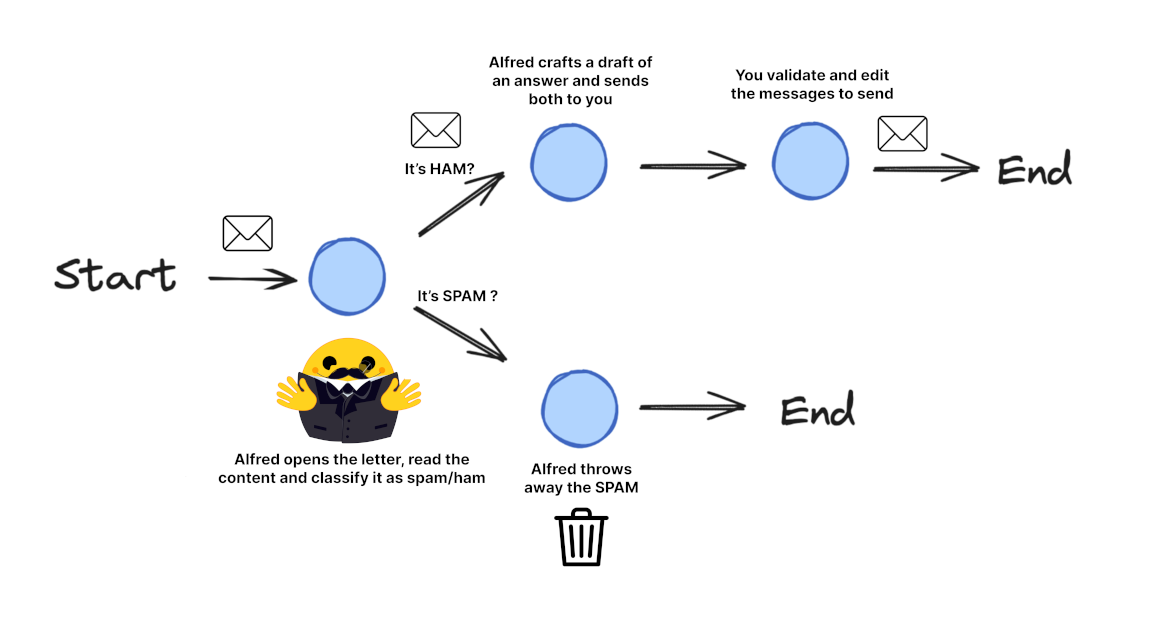

In [1]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

# os.environ["GOOGLE_API_KEY"] = os.environ["GEMINI_API_KEY"]
llm_model = "gemini-2.0-flash-lite" # "gemma-3-27b-it" # 

model = ChatGoogleGenerativeAI(
    model=llm_model,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## Step 1: Define Our State

💡 Tip: Make your state comprehensive enough to track all the important information, but avoid bloating it with unnecessary details.

In [3]:
class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Analysis and decisions
    is_spam: Optional[bool]
    
    # Response generation
    email_draft: Optional[str]
    
    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

## Step 2: Define Our Nodes

In [4]:
import json

def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]
    
    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    Return in JSON format:
    {{
        "is_spam": true/false,
        "spam_reason": "reason for spam" (if applicable),
        "email_category": "category" (if legitimate)
    }}
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    # print(f"LLM response: {response_text}")
    response_json = json.loads(response_text[response_text.find("```json")+7:response_text.rfind("```")].strip())
    is_spam = response_json.get("is_spam", False)
    # is_spam = "spam" in response_text and "not spam" not in response_text
    
    # Extract a reason if it's spam
    spam_reason = response_json.get("spam_reason", False)
    # if is_spam and "reason:" in response_text:
    #     spam_reason = response_json.get("spam_reason", None)
        # spam_reason = response_text.split("reason:")[1].strip()
    
    # Determine category if legitimate
    email_category = response_json.get("email_category", None)
    # email_category = None
    # if not is_spam:
    #     categories = ["inquiry", "complaint", "thank you", "request", "information"]
    #     for category in categories:
    #         if category in response_text:
    #             email_category = category
    #             break
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "email_draft": response.content,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")
    
    # We're done processing this email
    return {}

## Step 3: Define Our Routing Logic

💡 Note: This routing function is called by LangGraph to determine which edge to follow after the classification node. The return value must match one of the keys in our conditional edges mapping.

In [5]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

## Step 4: Create the StateGraph and Define Edges

In [6]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# Compile the graph
compiled_graph = email_graph.compile()

## Step 5: Run the Application

In [7]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about your services

Dear Mr. Smith,

Thank you for your email and your interest in my services. I would be pleased to learn more about your needs.

I am available for a call next week. Please let me know what days and times work best for you.

I look forward to speaking with you.

Sincerely,

Alfred


Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: the email exhibits several characteristics of spam: 1) the subject line uses excessive capitalization and promises a large sum of money, a common tactic. 2